# Fitting LoS distributions for HEP

* Primary Hip
* Revision Hip
* Primary Knee
* Revision Knee
* Unicompartmental Primary Knee
* Delayed Discharge

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [50]:
HipKnee_1320_mffd = pd.read_csv("HipKnee_with_los_delay.csv", usecols = ['admission_date',
                                                                         'discharge_date',
                                                                         'spell_los',
                                                                         'mffd',
                                                                         'cancelled_ops_non_clinical',
                                                                         'hip_prim_proc',
                                                                         'knee_prim_proc',
                                                                         'surgery_site'])

## Calculate proportions of surgical types within Hips and Knees

In [51]:
# All hips, all knees
length_hip = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['surgery_site'] == "Site: hip"] 
length_knee = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['surgery_site'] == "Site: knee"]

# hip types within all hips
primary_hip_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['hip_prim_proc'] == "Primary THR"]
revision_hip_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['hip_prim_proc'] == "Revision of hip"]
hip_resurfacing_n =  HipKnee_1320_mffd.loc[HipKnee_1320_mffd['hip_prim_proc'] == "Hip resurfacing"]

# knee types within all knees
primary_knee_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['knee_prim_proc'] == "Primary TKR"]
revision_knee_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['knee_prim_proc'] == "Revision of knee"]
unicompart_knee_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['knee_prim_proc'] == "Primary UKR"]


In [52]:
# counts for both delayed and not delayed
print(len(primary_hip_n), len(revision_hip_n), len(hip_resurfacing_n), len(primary_knee_n), len(revision_knee_n), len(unicompart_knee_n))

3057 482 52 2302 392 679


In [53]:
# prop of hip types within hips
prop_prim_hip = primary_hip_n.shape[0] / length_hip.shape[0]
prop_rev_hip = revision_hip_n.shape[0] / length_hip.shape[0]
prop_hip_resurfacing = hip_resurfacing_n.shape[0] / length_hip.shape[0]
tot_hips = prop_prim_hip + prop_rev_hip + prop_hip_resurfacing

# prop knee types within knees
prop_prim_knee = primary_knee_n.shape[0] / length_knee.shape[0]
prop_rev_knee = revision_knee_n.shape[0] / length_knee.shape[0]
prop_uncompart_knee = unicompart_knee_n.shape[0] / length_knee.shape[0]
tot_knees = prop_prim_knee + prop_rev_knee + prop_uncompart_knee

In [54]:
#proportions for both delayed and not delayed by joint
print(prop_prim_hip, prop_rev_hip, prop_prim_knee, prop_rev_knee, prop_uncompart_knee)

0.8616121758737317 0.1358511837655017 0.6738875878220141 0.11475409836065574 0.1987704918032787


## Calculate proportions of surgical types within classes: Primary and Revision

In [55]:
# prop primary types within primaries
prop_primary_hips = primary_hip_n.shape[0] / (primary_hip_n.shape[0] + primary_knee_n.shape[0] + unicompart_knee_n.shape[0])
prop_primary_knees = primary_knee_n.shape[0] / (primary_knee_n.shape[0] + primary_hip_n.shape[0] + unicompart_knee_n.shape[0])
prop_unicompart_knees = unicompart_knee_n.shape[0] / (primary_knee_n.shape[0] + primary_hip_n.shape[0] + unicompart_knee_n.shape[0])

# prop revision types within revisions
prop_revision_hips = revision_hip_n.shape[0] / (revision_hip_n.shape[0] + revision_knee_n.shape[0])
prop_revision_knees = revision_knee_n.shape[0] / (revision_hip_n.shape[0] + revision_knee_n.shape[0])

In [56]:
#proportions for both delayed and not delayed by primary/revision
print(prop_primary_hips, prop_primary_knees, prop_unicompart_knees, prop_revision_hips, prop_revision_knees)

0.5062934746604836 0.3812520702219278 0.1124544551175886 0.551487414187643 0.448512585812357


## Calculate proportion delayed

* Overall delay for all surgical types

In [57]:
# count of NOT delayed and proportion of delayed
delay_n = HipKnee_1320_mffd[HipKnee_1320_mffd['mffd'].isna()]
delay_prop = (HipKnee_1320_mffd.shape[0] - delay_n.shape[0]) / HipKnee_1320_mffd.shape[0]

In [58]:
# overall proportion of patients delayed
delay_prop

0.07596209075244112

In [59]:
# dataframes for checking - patients delayed per surgery
primary_knee_del = primary_knee_n[primary_knee_n['mffd'].notna()]
uni_knee_del = unicompart_knee_n[unicompart_knee_n['mffd'].notna()]
revise_knee_del = revision_knee_n[revision_knee_n['mffd'].notna()]
primary_hip_del = primary_hip_n[primary_hip_n['mffd'].notna()]
revise_hip_del = revision_hip_n[revision_hip_n['mffd'].notna()]

# df patients not delayed
primary_knee = primary_knee_n[primary_knee_n['mffd'].isna()]
uni_knee = unicompart_knee_n[unicompart_knee_n['mffd'].isna()]
revise_knee = revision_knee_n[revision_knee_n['mffd'].isna()]
primary_hip = primary_hip_n[primary_hip_n['mffd'].isna()]
revise_hip = revision_hip_n[revision_hip_n['mffd'].isna()]

# checking proportions per surgery - compare with overall proportion delayed
prop_primary_knee_del = primary_knee_del.shape[0] / (primary_knee.shape[0] + primary_knee_del.shape[0])
prop_revision_knee_del = revise_knee_del.shape[0] / (revise_knee.shape[0] + revise_knee_del.shape[0])
prop_unicom_knee_del = uni_knee_del.shape[0] / (uni_knee.shape[0] + uni_knee_del.shape[0])
prop_primary_hip_del = primary_hip_del.shape[0] / (primary_hip.shape[0] + primary_hip_del.shape[0])
prop_revison_hip_del = revise_hip_del.shape[0] / (revise_hip.shape[0] + revise_hip_del.shape[0])

In [60]:
# proportion of patients delayed per surgery type
print(prop_primary_hip_del, prop_primary_knee_del, prop_revison_hip_del, prop_revision_knee_del, prop_unicom_knee_del)

0.0775269872423945 0.06602953953084274 0.15767634854771784 0.1326530612244898 0.016200294550810016


## Vectors for fitting no delay LoS
* Save to csv for using empirical distributions in model

In [69]:
primary_knee_v = primary_knee['spell_los'].tolist()
uni_knee_v = uni_knee['spell_los'].tolist()
revise_knee_v = revise_knee['spell_los'].tolist()
primary_hip_v = primary_hip['spell_los'].tolist()
revise_hip_v = revise_hip['spell_los'].tolist()

series_dict = {'Primary Knee': pd.Series(primary_knee_v),
               'Unicompart Knee': pd.Series(uni_knee_v),
               'Revision Knee': pd.Series(revise_knee_v),
               'Primary Hip': pd.Series(primary_hip_v),
               'Revision Hip': pd.Series(revise_hip_v)}

#save to df with 0 changed to very small number
df = pd.DataFrame(series_dict)
df.replace(to_replace = 0, value = 0.0001, inplace=True)
df.to_csv('los_spells.csv', index=False)

######################################################
#save to df with 0 eliminated
a = [i for i in primary_knee_v if i != 0]
b = [i for i in uni_knee_v if i != 0]
c = [i for i in revise_knee_v if i != 0]
d = [i for i in primary_hip_v if i != 0]
e = [i for i in revise_hip_v if i != 0]

nonzero_dict = {'Primary Knee': pd.Series(a),
               'Unicompart Knee': pd.Series(b),
               'Revision Knee': pd.Series(c),
               'Primary Hip': pd.Series(d),
               'Revision Hip': pd.Series(e)}

df2 = pd.DataFrame(nonzero_dict)
df2.to_csv('los_spells_no_zero.csv', index=False)

## Los vector for delayed discharge (all surgical types)

In [30]:
delayed_los = HipKnee_1320_mffd[HipKnee_1320_mffd['mffd'].notna()]
delayed_los_v = delayed_los['spell_los'].tolist()

## Plot LoS distributions
* Summarise

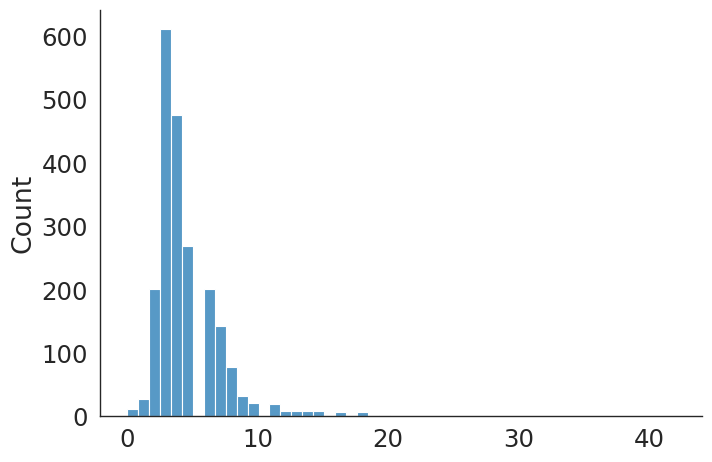

In [31]:
#plt.hist(primary_knee_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=primary_knee_v, kind="hist", bins = 50, aspect = 1.5)

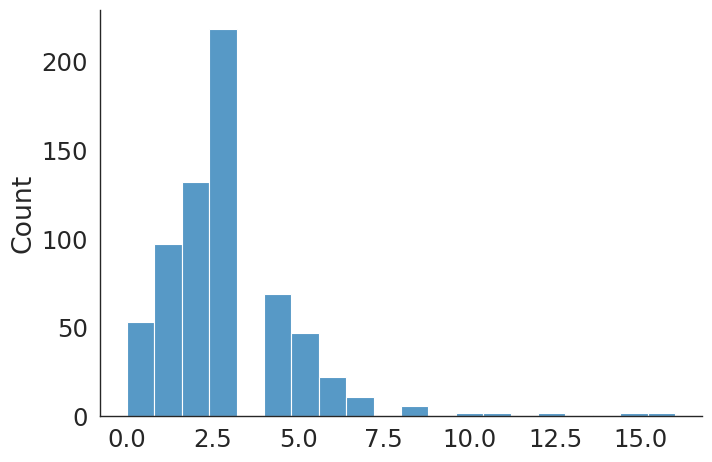

In [32]:
#plt.hist(uni_knee_v, bins=20);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=uni_knee_v, kind="hist", bins = 20, aspect = 1.5)

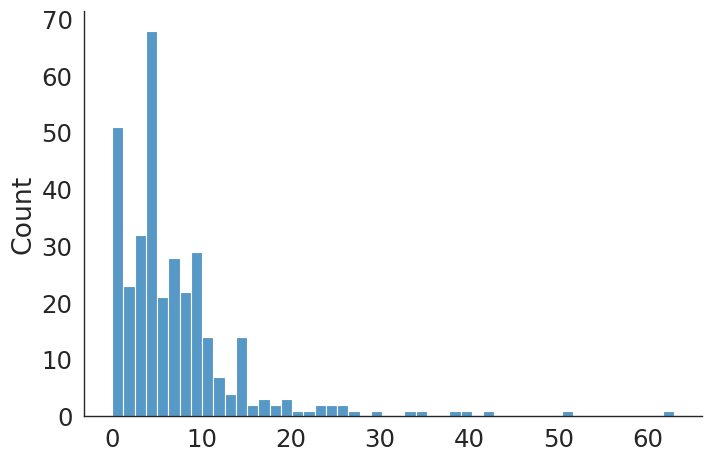

In [33]:
#plt.hist(revise_knee_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=revise_knee_v, kind="hist", bins = 50, aspect = 1.5)

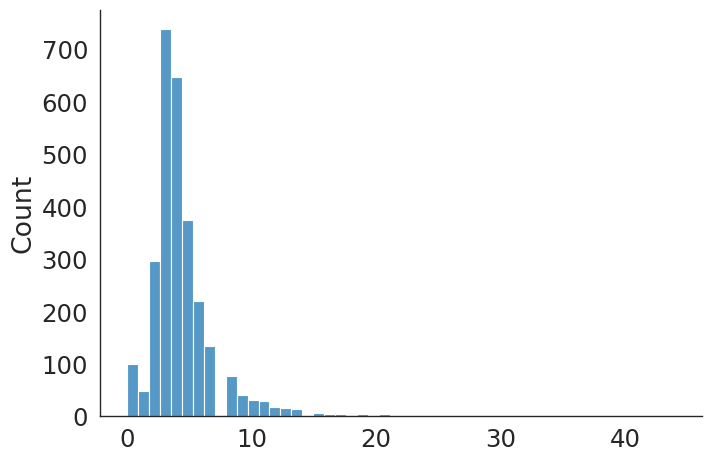

In [34]:
#plt.hist(primary_hip_v, bins=50);
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=primary_hip_v, kind="hist", bins = 50, aspect = 1.5)

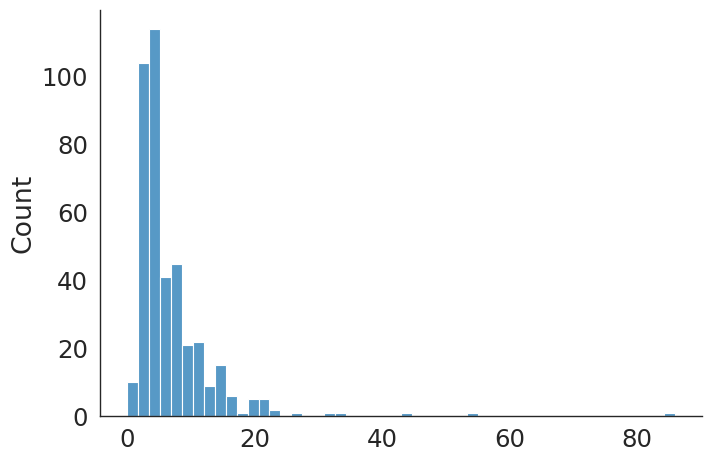

In [35]:
#plt.hist(revise_hip_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(revise_hip_v, kind="hist", bins = 50, aspect = 1.5)

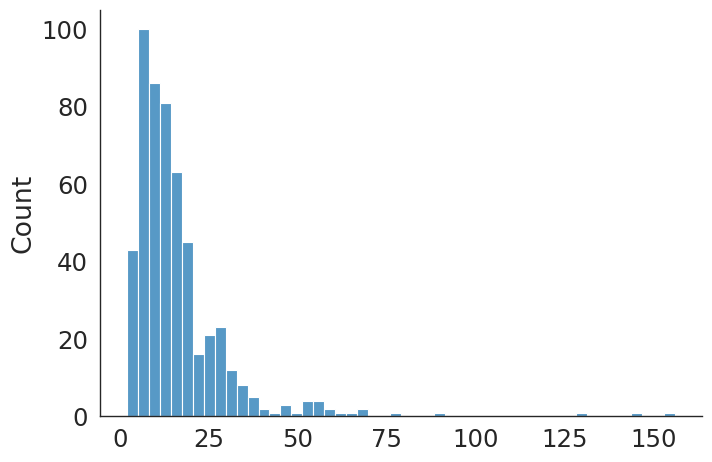

In [36]:
#plt.hist(delayed_los_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(delayed_los_v, kind="hist", bins = 50, aspect = 1.5)

In [37]:
delay_los_pdv = pd.Series(delayed_los_v)
print("delay_los", delay_los_pdv.describe())

primary_knee_pdv = pd.Series(primary_knee_v)
print("primary_knee", primary_knee_pdv.describe())

uni_knee_pdv = pd.Series(uni_knee_v)
print("uni_knee", uni_knee_pdv.describe())

revise_knee_pdv = pd.Series(revise_knee_v)
print("revise_knee", revise_knee_pdv.describe())

primary_hip_pdv = pd.Series(primary_hip_v)
print("primary_hip", primary_hip_pdv.describe())

revise_hip_pdv = pd.Series(revise_hip_v)
print("revise_hip", revise_hip_pdv.describe())

delay_los count    529.000000
mean      16.521739
std       15.153132
min        2.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      156.000000
dtype: float64
primary_knee count    2150.000000
mean        4.651163
std         2.828129
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        42.000000
dtype: float64
uni_knee count    668.000000
mean       2.914671
std        2.136334
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       16.000000
dtype: float64
revise_knee count    340.000000
mean       7.194118
std        7.598554
min        0.000000
25%        3.000000
50%        5.000000
75%        9.000000
max       63.000000
dtype: float64
primary_hip count    2820.000000
mean        4.433333
std         2.949526
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        44.000000
dtype: float64
revise_hip count    406.000000
mean       6.908867
st

# Convert to NumPy arrays for use in Fitter

In [38]:
delay_los_npv = np.asarray(delayed_los_v)
primary_knee_npv = np.asarray(primary_knee_v)
uni_knee_npv = np.asarray(uni_knee_v)
revise_knee_npv = np.asarray(revise_knee_v)
primary_hip_npv = np.asarray(primary_hip_v)
revise_hip_npv = np.asarray(revise_hip_v)

In [39]:
get_distributions()

['_fit',
 'alpha',
 'anglit',
 'arcsine',
 'argus',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'crystalball',
 'dgamma',
 'dweibull',
 'erlang',
 'expon',
 'exponnorm',
 'exponpow',
 'exponweib',
 'f',
 'fatiguelife',
 'fisk',
 'foldcauchy',
 'foldnorm',
 'gamma',
 'gausshyper',
 'genexpon',
 'genextreme',
 'gengamma',
 'genhalflogistic',
 'genhyperbolic',
 'geninvgauss',
 'genlogistic',
 'gennorm',
 'genpareto',
 'gibrat',
 'gilbrat',
 'gompertz',
 'gumbel_l',
 'gumbel_r',
 'halfcauchy',
 'halfgennorm',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'invgamma',
 'invgauss',
 'invweibull',
 'johnsonsb',
 'johnsonsu',
 'kappa3',
 'kappa4',
 'ksone',
 'kstwo',
 'kstwobign',
 'laplace',
 'laplace_asymmetric',
 'levy',
 'levy_l',
 'levy_stable',
 'loggamma',
 'logistic',
 'loglaplace',
 'lognorm',
 'loguniform',
 'lomax',
 'maxwell',
 'mielke',
 'moyal',
 'nakagami',
 'ncf',
 'nct',
 'ncx2',
 'norm',
 'norminvgauss',
 'pareto',
 'pearson3'

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 20.26it/s]

         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.004644  1608.122559 -6140.474568     inf      0.051474   
beta            0.005357  1924.655190 -6058.553177     inf      0.087312   
erlang          0.005441  1895.761508 -6056.655095     inf      0.088753   
expon           0.009436  1599.608397 -5771.632045     inf      0.162747   
gamma           0.035865  6380.344444 -5059.053541     inf      0.921926   

            ks_pvalue  
lognorm  1.170505e-01  
beta     5.866521e-04  
erlang   4.477466e-04  
expon    1.037166e-12  
gamma    0.000000e+00  


{'lognorm': {'s': 0.6977106156387711,
  'loc': 0.46203959259225885,
  'scale': 12.381893465319441}}

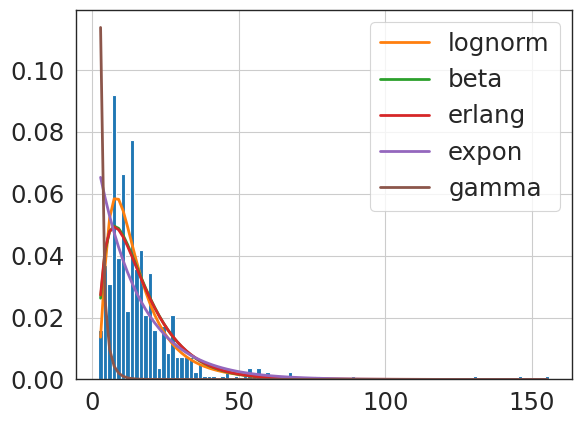

In [25]:
f = Fitter(delay_los_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon',
                          'erlang'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 16.74it/s]

         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.578484  1860.575987 -17651.201383     inf      0.151704   
expon           0.792283  1214.423450 -16982.682686     inf      0.363244   
beta            0.904699  1153.425425 -16682.064683     inf      0.427036   
erlang          0.957660  4442.059841 -16567.424259     inf      0.992310   
gamma           1.696721  2924.646338 -15337.709648     inf      0.872199   

             ks_pvalue  
lognorm   1.150099e-43  
expon    1.064843e-254  
beta      0.000000e+00  
erlang    0.000000e+00  
gamma     0.000000e+00  


{'lognorm': {'s': 0.4054742453283533,
  'loc': -1.0156970361318063,
  'scale': 5.187968679570998}}

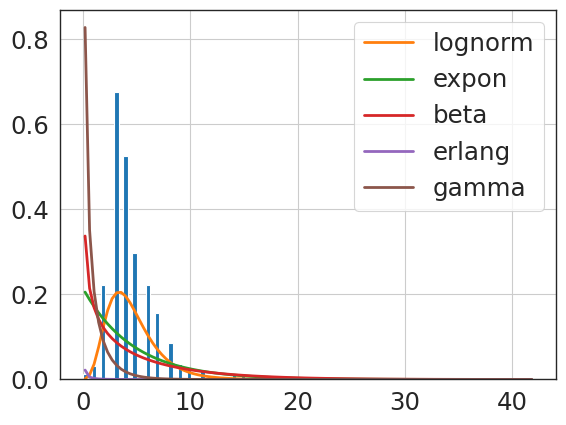

In [41]:
f = Fitter(primary_knee_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon',
                          'erlang'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 26.33it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         6.349747   924.541981 -3090.610424     inf      0.171962   
gamma           6.363627   945.514562 -3089.151847     inf      0.167334   
beta            6.373490   921.072492 -3081.613030     inf      0.168304   
expon           6.603280   766.898464 -3070.961471     inf      0.271955   
erlang          7.357514  3288.577391 -2992.209312     inf      0.919689   

            ks_pvalue  
lognorm  9.648984e-18  
gamma    8.102790e-17  
beta     5.212017e-17  
expon    3.872916e-44  
erlang   0.000000e+00  


{'lognorm': {'s': 0.3803355622865142,
  'loc': -2.1623715729774657,
  'scale': 4.71533144760631}}

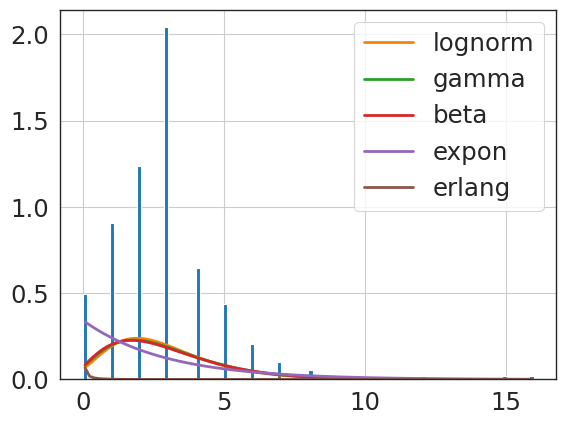

In [42]:
f = Fitter(uni_knee_pdv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon',
                          'erlang'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 23.30it/s]

         sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon           0.068790  1274.368194 -2880.262979     inf      0.123337   
beta            0.100426  1301.742494 -2739.959169     inf      0.310421   
lognorm         0.118113  1229.635547 -2690.633827     inf      0.366558   
erlang          0.170774  5154.728107 -2565.275127     inf      0.895442   
gamma           0.398495  4032.310584 -2277.175334     inf      0.699071   

             ks_pvalue  
expon     5.759763e-05  
beta      1.342060e-29  
lognorm   1.816040e-41  
erlang    0.000000e+00  
gamma    5.534748e-167  


{'expon': {'loc': 0.0, 'scale': 7.194117647058824}}

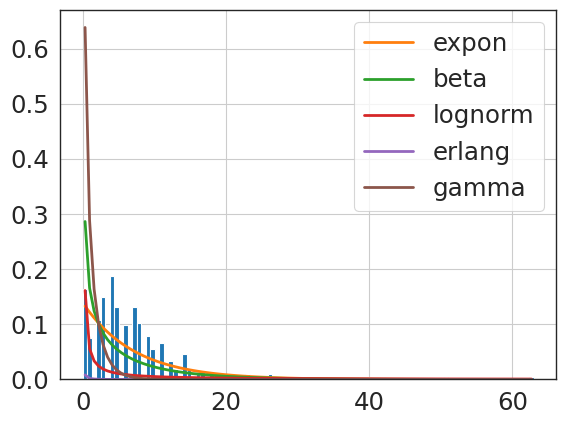

In [43]:
f = Fitter(revise_knee_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon',
                          'erlang'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 19.89it/s]

         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.509158  1963.042781 -24283.125652     inf      0.166587   
beta            0.516464  2432.283680 -24235.005142     inf      0.168023   
expon           0.654193  1294.311552 -23584.255723     inf      0.334257   
gamma           0.686329  1119.561080 -23441.078834     inf      0.325523   
erlang          0.828594  4614.364362 -22909.864887     inf      0.962388   

             ks_pvalue  
lognorm   7.205752e-69  
beta      4.630348e-70  
expon    2.091397e-281  
gamma    1.536661e-266  
erlang    0.000000e+00  


{'lognorm': {'s': 0.3615166592899655,
  'loc': -2.4363376840086204,
  'scale': 6.4116655364890836}}

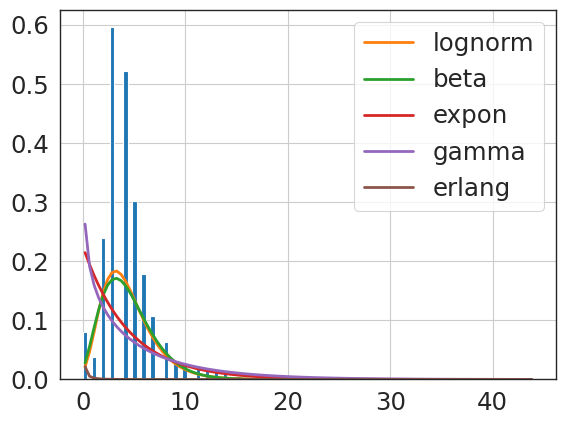

In [44]:
f = Fitter(primary_hip_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon',
                          'erlang'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 22.41it/s]

         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.022496  1733.019612 -3961.087365     inf      0.107411   
beta            0.033304  2128.183021 -3795.802654     inf      0.142546   
expon           0.059486  1635.338315 -3572.307506     inf      0.241396   
erlang          0.130983  5711.381127 -3245.831210     inf      0.983865   
gamma           0.138877  3996.315953 -3222.070957     inf      0.938027   

            ks_pvalue  
lognorm  1.559684e-04  
beta     1.162057e-07  
expon    2.614308e-21  
erlang   0.000000e+00  
gamma    0.000000e+00  


{'lognorm': {'s': 0.6152292643165856,
  'loc': -0.934387442319201,
  'scale': 6.350152207311825}}

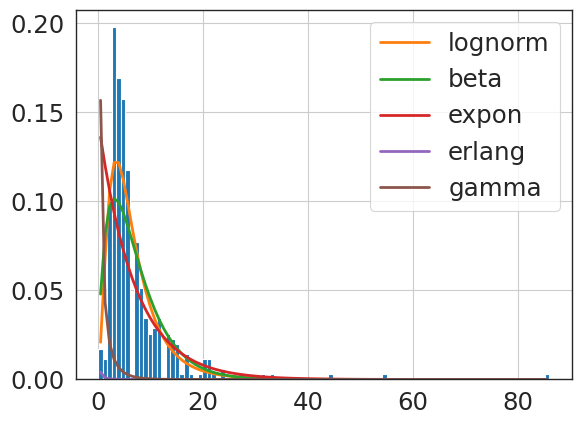

In [40]:
f = Fitter(revise_hip_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon',
                          'erlang'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

In [ ]:
f.get_best(method = 'sumsquare_error')

## Clip arrays

In [ ]:
delay_los_npv_clip = np.asarray(delayed_los_v) # leave as is
primary_knee_npv_clip = np.clip(np.asarray(primary_knee_v), 0, 30)
uni_knee_npv_clip = np.clip(np.asarray(uni_knee_v), 0, 30)
revise_knee_npv_clip = np.clip(np.asarray(revise_knee_v), 0, 30)
primary_hip_npv_clip = np.clip(np.asarray(primary_hip_v), 0, 30)
revise_hip_npv_clip = np.clip(np.asarray(revise_hip_v), 0, 30)

## Fit clipped data

In [ ]:
f = Fitter(primary_knee_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

In [ ]:
f = Fitter(uni_knee_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

In [ ]:
f = Fitter(revise_knee_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

In [ ]:
f = Fitter(primary_hip_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

In [ ]:
f = Fitter(revise_hip_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

## Summarise clipped data

In [ ]:
delay_los_pdv = pd.Series(delay_los_npv_clip)
print("delay_los", delay_los_pdv.describe())

primary_knee_pdv = pd.Series(primary_knee_npv_clip)
print("primary_knee", primary_knee_pdv.describe())

uni_knee_pdv = pd.Series(uni_knee_npv_clip)
print("uni_knee", uni_knee_pdv.describe())

revise_knee_pdv = pd.Series(revise_knee_npv_clip)
print("revise_knee", revise_knee_pdv.describe())

primary_hip_pdv = pd.Series(primary_hip_npv_clip)
print("primary_hip", primary_hip_pdv.describe())

revise_hip_pdv = pd.Series(revise_hip_npv_clip)
print("revise_hip", revise_hip_pdv.describe())


## check empirical dist used in model

In [94]:
random_number_set = None
rng_streams = np.random.default_rng(random_number_set)
seeds = rng_streams.integers(0,99999999999, size = 20)



def dist(los_data, random_seed = None):
    rng = np.random.default_rng(seed = random_seed)
    return rng.choice(los_data, size=None, replace=True)

In [98]:
x = dist(delay_los_npv, random_seed=seeds[2])
print(x)
y = dist(delay_los_npv, random_seed=seeds[2])
print(y)

27
27


In [88]:
array([ 6, 14, 13, 13, 18, 11, 11,  2, 11, 22, 15,  7, 17, 15, 14,  8, 15,
       10, 67, 18, 14, 13, 11, 11, 13, 10,  5, 13, 14, 29, 14,  5, 11, 31,
        8,  4, 15, 15,  8, 20, 57, 24, 14,  8,  8, 14, 13, 29, 24,  8, 56,
        8,  2,  6, 19, 14,  8, 27, 19, 22,  7,  5, 15, 13,  7, 15, 16, 11,
       26,  6,  6, 21,  5, 30, 11, 12,  3, 27, 11, 14, 16, 24,  5,  8, 21,
       15, 24,  8, 41,  9,  8,  7,  7, 14, 29, 13, 35, 12, 12, 27

SyntaxError: unexpected EOF while parsing (577671933.py, line 6)